# CSCI4022 Final Project; Colorado Avalanches


***

- I am using data for avalanches in Vail and Summit County from the Colorado Avalanche Information Center. The CAIC website allowed me to compile a report of all Avalanches recorded in Colorado from October 2010 to April 2021. My data includes information on the start elevation of the avalanche and the average width of the avalanche.
---

In [2]:
#I will be using the k-means clustering convention used in class
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Read in historic avalanche data from CAIC file
avalanche = pd.read_csv("CAIC_avalanches.csv", encoding = 'UTF-8', skip_blank_lines = False)

#Get the names of the columns to aid in manipulation
colnames = list(avalanche.columns)
print(colnames)

#clean the data to discard unneeded information and records missing important information
avalanche.index = avalanche['Obs ID']
avalanche = avalanche.drop(columns = ['Obs ID', 'Date Known', 'Time', 'Time Known', 'HW Zone', 'Operation', 'First Name', 'Last Name', 'HW Path', 'Trigger', 'Trigger_sub', 'Comments', 'Sliding Sfc', 'Avg Vertical', 'Max Vertical', 'Vertical units', 'Avg Crown Height', 'Max Crown Height', 'Crown Height units', 'Terminus '])
avalanche = avalanche.dropna(subset = ['Start Zone Elev', 'Avg Width'])

#the highest start zone elevation in the data set is 39,990ft which would be an error
#since the tallest peak in Colorado is 14,439ft
avalanche = avalanche.drop(avalanche['Start Zone Elev'].idxmax())

#print some data so we can see what we are working with
avalanche.head()

['Obs ID', 'Date', 'Date Known', 'Time', 'Time Known', 'BC Zone', 'HW Zone', 'Operation', 'Landmark', 'First Name', 'Last Name', 'HW Path', '#', 'Elev', 'Asp', 'Type', 'Trigger', 'Trigger_sub', 'Rsize', 'Dsize', 'Incident', 'Area Description', 'Comments', 'Avg Slope Angle', 'Start Zone Elev', 'Start Zone Elev units', 'Sliding Sfc', 'Weak Layer', 'Weak Layer Type', 'Avg Width', 'Max Width', 'Width units', 'Avg Vertical', 'Max Vertical', 'Vertical units', 'Avg Crown Height', 'Max Crown Height', 'Crown Height units', 'Terminus ']


,Date,BC Zone,Landmark,#,Elev,Asp,Type,Rsize,Dsize,Incident,Area Description,Avg Slope Angle,Start Zone Elev,Start Zone Elev units,Weak Layer,Weak Layer Type,Avg Width,Max Width,Width units
Obs ID,,,,,,,,,,,,,,,,,,,
66783,2021/04/23,Vail & Summit County,buffalo Mountain,1.0,>TL,N,SS,R1,D1.5,NaN,Maximum Elvis,NaN,12400.0,ft,NaN,NaN,50.0,NaN,ft
66780,2021/04/23,Front Range,Herman Gulch,1.0,>TL,S,SS,R1,D1.5,NaN,Woods Mountain,NaN,12800.0,ft,NaN,NaN,100.0,NaN,ft
66738,2021/04/20,Vail & Summit County,10-mile Range,1.0,>TL,SW,SS,R1,D1.5,NaN,Pacific Peak,38.0,13300.0,ft,Layer,Faceted Crystals,100.0,NaN,ft
66538,2021/04/05,Northern San Juan,NaN,1.0,<TL,NE,WS,R1,D2,NaN,NaN,45.0,10800.0,ft,NaN,NaN,40.0,NaN,ft
66504,2021/04/04,Northern San Juan,NaN,4.0,<TL,W,WS,R2,D2,NaN,C-H,35.0,10800.0,ft,NaN,NaN,80.0,120.0,ft


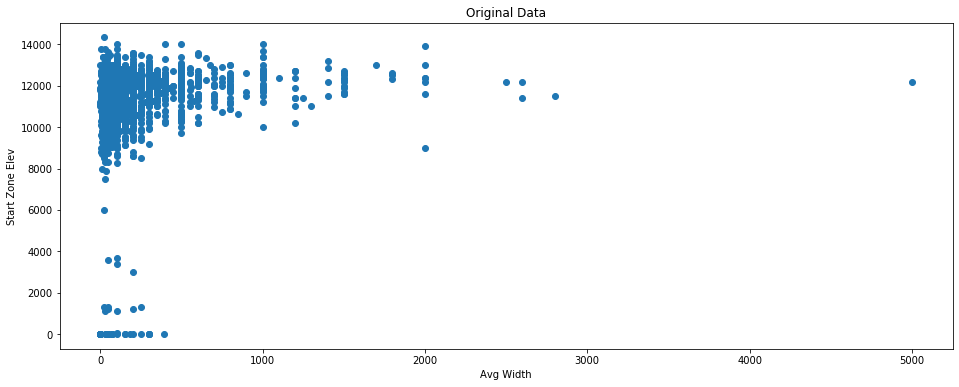

In [3]:
#Plot the Start Zone Elevation against Average width to see where different sized avalanches occur
fig, ax = plt.subplots(figsize=(16,6))
plt.scatter(avalanche['Avg Width'], avalanche['Start Zone Elev'])
ax.set_xlabel('Avg Width')
ax.set_ylabel('Start Zone Elev')
ax.set_title('Original Data')
plt.show()

The plot 'Original Data' gives an illistration of the data being worked on before clustering. 

In [4]:
avalanche.describe()

,#,Avg Slope Angle,Start Zone Elev,Avg Width,Max Width
count,2572.000000,1560.000000,2572.000000,2572.000000,1463.000000
mean,1.388802,34.612179,11278.897745,178.833546,183.835954
std,1.332243,8.586292,2089.625102,284.195259,258.441216
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,34.000000,11000.000000,40.000000,50.000000
50%,1.000000,35.000000,11800.000000,100.000000,100.000000
75%,1.000000,39.000000,12200.000000,200.000000,200.000000
max,20.000000,65.000000,14336.000000,5000.000000,3000.000000


In [5]:
def dist(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

#used HW3 solutions to help create a function for clustering
def cluster(aval_data):
    #cluster into 5 clusters to get more distinction between groups
    K = 5
    #initialize k random choices for indexes of avalance data for centroids
    clocs = np.random.choice(range(len(aval_data)), size=K)

    #set initial k centroids using random initialization choices
    centroids = np.array([aval_data.iloc[clocs[0]], aval_data.iloc[clocs[1]], aval_data.iloc[clocs[2]], aval_data.iloc[clocs[3]], aval_data.iloc[clocs[4]]])
    #print('data set is on',len(centroids[0]))
    #initialize array to store distance of a point from each centroid
    dists = [0]*K
    #initialize array to store clustering choices
    clusters = np.array([-1]*len(aval_data))
    for i in range(50): #50 steps
        #update classifications by looping through each data point
        for j in range(len(aval_data)):
            #calculate distances between points and centroids
            dists = [dist(aval_data.iloc[j], cent) for cent in centroids]
            #assign point to closest cluster by taking min distance 
            assignment = dists.index(min(dists))
            #add cluster assignment to array
            clusters[j] = assignment
        #update centroids
        for j in range(K):
            #update centroids for data clustering on start zone elevation and average width
            if len(centroids[0])==2:
                #print('did 2 centroid update:')
                centroids[j]=[np.sum(aval_data.iloc[clusters==j,0])/len(aval_data.iloc[clusters==j,0]),\
                              np.sum(aval_data.iloc[clusters==j,1])/len(aval_data.iloc[clusters==j,1])]
            #update centroids for data clustering on average slope angle, start zone elevation, and average width
            elif len(centroids[0])==3:
                #print('did 3 centroid update')
                centroids[j]=[np.sum(aval_data.iloc[clusters==j,0])/len(aval_data.iloc[clusters==j,0]),\
                              np.sum(aval_data.iloc[clusters==j,1])/len(aval_data.iloc[clusters==j,1]),\
                              np.sum(aval_data.iloc[clusters==j,2])/len(aval_data.iloc[clusters==j,2])]
            else:
                centroids[j]=[np.sum(aval_data.iloc[clusters==j,0])/len(aval_data.iloc[clusters==j,0]),\
                              np.sum(aval_data.iloc[clusters==j,1])/len(aval_data.iloc[clusters==j,1]),\
                              np.sum(aval_data.iloc[clusters==j,2])/len(aval_data.iloc[clusters==j,2]),\
                              np.sum(aval_data.iloc[clusters==j,3])/len(aval_data.iloc[clusters==j,3])]
    #return the final clusters
    return clusters
            
#clean out other unneeded columns
aval_elev_vs_size = avalanche.drop(columns = ['#', 'Date', 'BC Zone', 'Landmark', 'Elev', 'Asp', 'Type', 'Rsize', 'Dsize', 'Incident', 'Area Description', 'Avg Slope Angle', 'Start Zone Elev units', 'Weak Layer', 'Weak Layer Type', 'Width units', 'Max Width'])
#get the clusters for data based on start zone elevation and average width
clusters = cluster(aval_elev_vs_size)

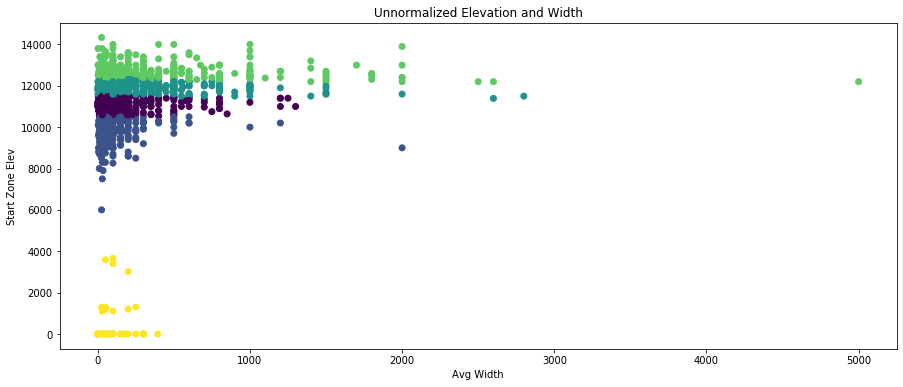

In [6]:
def plotCluster(pl_aval_elev_vs_size, pl_clusters, pl_title):
    fig, ax = plt.subplots(figsize=(15,6))
    plt.scatter(pl_aval_elev_vs_size['Avg Width'], pl_aval_elev_vs_size['Start Zone Elev'], c=pl_clusters)
    ax.set_xlabel('Avg Width')
    ax.set_ylabel('Start Zone Elev')
    ax.set_title(pl_title)
    plt.show()
    return
#plot clusters from unnormalized elevation and width
plotCluster(aval_elev_vs_size, clusters, 'Unnormalized Elevation and Width')

The standard deviation on the start zone elevation is way higher than average width of the avalanche. The data clusters look like they are being heavily influenced by the start zone elevation. I need to normalize my data before clustering to see if I can get better clusters. 

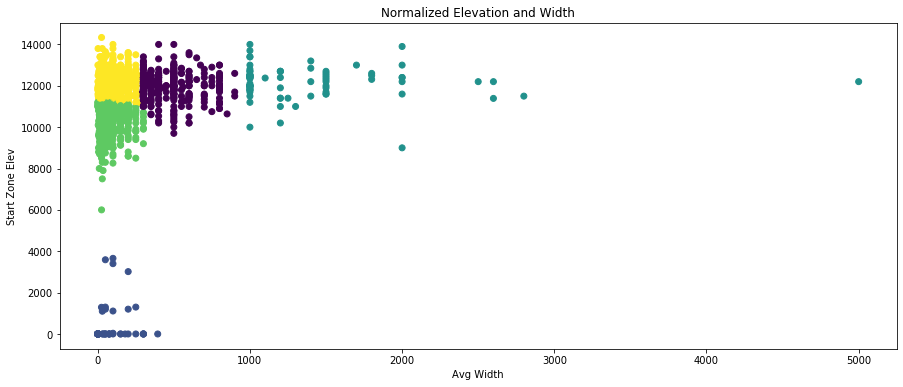

In [7]:
#HW3 referenced for .mean and .std
def normalize(aval_data):
    aval_n = aval_data.copy()
    means = aval_n.mean()
    sds = aval_n.std()
    #subtract mean from original data and divide by the standard deviation to normalize
    aval_n = (aval_n-means)/sds
    return aval_n
   
#normalize elevation and width data
norm_data = normalize(aval_elev_vs_size)
#cluster on the normalized data
norm_clusters = cluster(norm_data)
#plot clusters from normalized data
plotCluster(aval_elev_vs_size, norm_clusters, 'Normalized Elevation and Width')

The normalized data gives more consistent clustering. It looks like below 6000ft of elevation, the chance of avalanches is low and in the chance on an avalanche happening, it will be under 500ft in width. The yellow cluster shows if you trigger an avalanche at 6000ft to about 11000ft, it will most likely be under 500ft in width. When avalanches are triggered between 11000ft to 14000ft, it is most likely below 1000ft in width but this elevation has the highest chance of having an avalanche over 1000ft in width. I want to add the average slope angle to the clustering data and see if what impact this has on where points are clustered. 

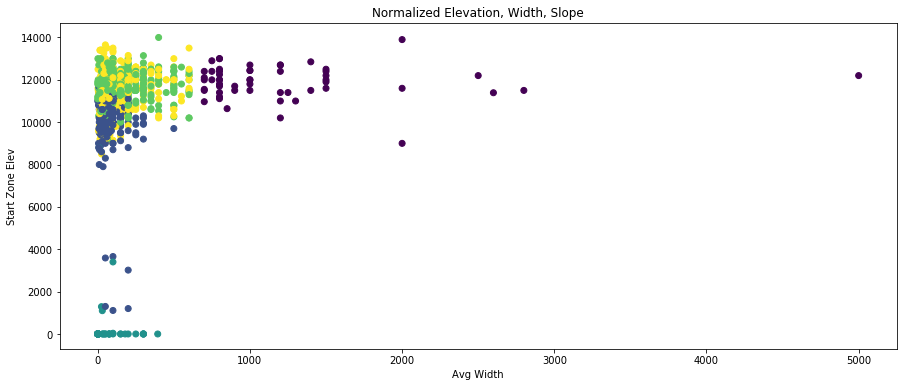

In [8]:
#avalanche data with start elevation, average width, and average slope angle
aval_elev_size_slope = avalanche.drop(columns = ['#', 'Date', 'BC Zone', 'Landmark', 'Elev', 'Asp', 'Type', 'Rsize', 'Dsize', 'Incident', 'Area Description', 'Start Zone Elev units', 'Weak Layer', 'Weak Layer Type', 'Width units', 'Max Width'])
#discard data with unknown slope angles
aval_elev_size_slope = aval_elev_size_slope.dropna(subset = ['Avg Slope Angle'])
#aval_elev_size_slope.describe()

#I know normalizianing will give better results based off the first clustering so start with normalized data
norm_data = normalize(aval_elev_size_slope)
#cluster the normalized data using start elevation, average width, and average slope angle
norm_clusters = cluster(norm_data)
#print(len(norm_data),len(norm_clusters))
#display the final clusters from start elevation, average width, and average slope angle
plotCluster(aval_elev_size_slope, norm_clusters, 'Normalized Elevation, Width, Slope')

The clusters are harder to distinguish so try plotting avg slope instead of start zone elevation to get a more clear representation.

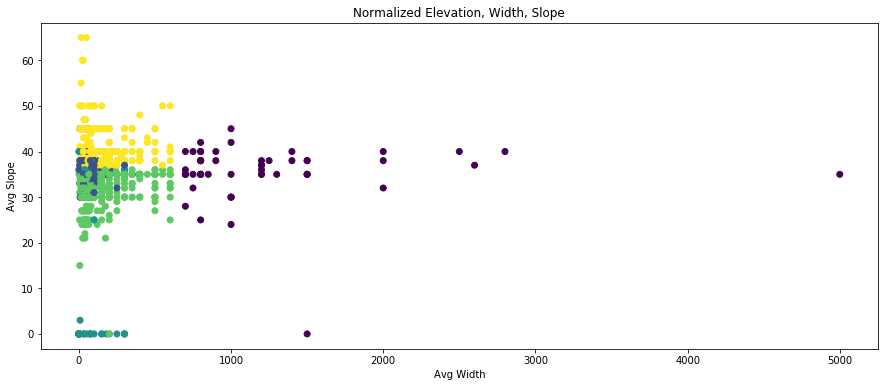

In [9]:
#try plotting avg slope instead of start zone elevation 
fig, ax = plt.subplots(figsize=(15,6))
plt.scatter(aval_elev_size_slope['Avg Width'], aval_elev_size_slope['Avg Slope Angle'], c=norm_clusters)
ax.set_xlabel('Avg Width')
ax.set_ylabel('Avg Slope')
ax.set_title('Normalized Elevation, Width, Slope')
plt.show()

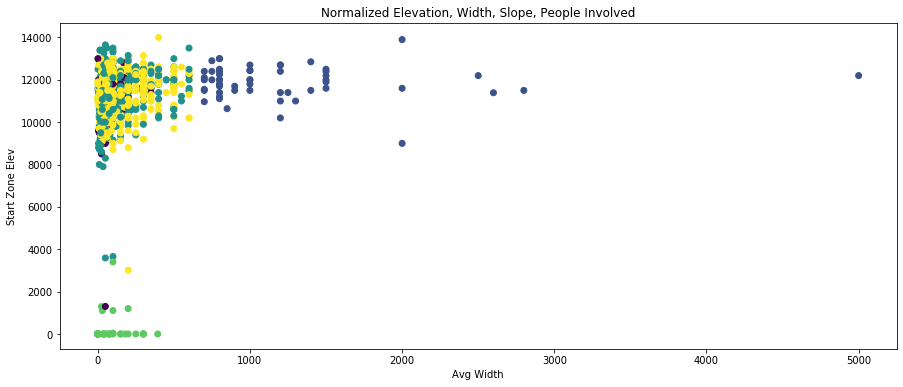

In [10]:
#avalanche data with start elevation, average width, average slope angle, and # (num of people involved)
aval_elev_size_slope = avalanche.drop(columns = ['Date', 'BC Zone', 'Landmark', 'Elev', 'Asp', 'Type', 'Rsize', 'Dsize', 'Incident', 'Area Description', 'Start Zone Elev units', 'Weak Layer', 'Weak Layer Type', 'Width units', 'Max Width'])
#discard data with unknown slope angles
aval_elev_size_slope = aval_elev_size_slope.dropna(subset = ['Avg Slope Angle', '#'])
#aval_elev_size_slope.describe()

#I know normalizianing will give better results based off the first clustering so start with normalized data
norm_data = normalize(aval_elev_size_slope)
#cluster the normalized data using start elevation, average width, average slope angle, and # (num of people involved)
norm_clusters = cluster(norm_data)
#print(len(norm_data),len(norm_clusters))
#display the final clusters from start elevation, average width, and average slope angle
plotCluster(aval_elev_size_slope, norm_clusters, 'Normalized Elevation, Width, Slope, People Involved')